In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/silence"))
#print(os.listdir("../input/tensorflow-speech-recognition-challenge"))
#print(os.listdir("../input/tensorflow-speech-recognition-challenge/train/audio"))
#print(len(os.listdir('../input/ssssss/silence')))
#print(os.listdir("../input/test"))
# Any results you write to the current directory are saved as output.

['tensorflow-speech-recognition-challenge', 'silence']
['silence']


In [2]:
from scipy.io import wavfile

from scipy import signal
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelBinarizer

import keras

from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Input, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam
#from keras.callbacks import TensorBoard

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
#os.mkdir('silence')

In [4]:
"""
def create_silence():
    
    #for i in range(1500):  #create 1500 sample
    seq=np.random.randint(6,size=(1500))
    ii=0
    for i in seq:
        cur_path='../input/train/audio/_background_noise_/'+silence_path[i]
        fs,x=wavfile.read(cur_path)
        start=np.random.randint(len(x)-16000+1)
        x=0.01*x[start:start+16000]
        wavfile.write('silence/'+'%d.wav'%(ii),fs,x)  #fs应该不变吧
        ii+=1
    return None 
    
    x=np.zeros((16000),dtype='int16')
    wavfile.write('silence/'+'1.wav',16000,x)  #fs应该不变吧
    return None
"""

"\ndef create_silence():\n    \n    #for i in range(1500):  #create 1500 sample\n    seq=np.random.randint(6,size=(1500))\n    ii=0\n    for i in seq:\n        cur_path='../input/train/audio/_background_noise_/'+silence_path[i]\n        fs,x=wavfile.read(cur_path)\n        start=np.random.randint(len(x)-16000+1)\n        x=0.01*x[start:start+16000]\n        wavfile.write('silence/'+'%d.wav'%(ii),fs,x)  #fs应该不变吧\n        ii+=1\n    return None \n    \n    x=np.zeros((16000),dtype='int16')\n    wavfile.write('silence/'+'1.wav',16000,x)  #fs应该不变吧\n    return None\n"

In [5]:
#create_silence()

In [6]:
#print(os.listdir('silence'))

In [7]:
import matplotlib.pyplot as plt

In [8]:
def get_train_path(path):  #end with '/'
    path_list=[]
    label_list=[]
    for species in os.listdir(path):
        if species=='_background_noise_':
            for file in os.listdir('../input/silence/silence/'):
                if file.split('.')[-1]=='wav':
            #for i in range(200):
                    path_list.append('../input/silence/silence/'+file)
                    label_list.append(species)    
        else:
            for file in os.listdir(path+species):
                if file.split('.')[-1]=='wav':
                    path_list.append(path+species+r'/'+file)
                    label_list.append(species)
    return path_list,label_list

In [9]:
def get_test_path(path):  #end with '/'
    path_list=[]
    id_list=[]
    for file in os.listdir(path):
        if file.split('.')[-1]=='wav':
            path_list.append(path+file)
            id_list.append(file)
    return path_list,id_list

In [10]:
train=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
silence = ['_background_noise_']
name2id={'yes':0, 'no':1, 'up':2, 'down':3, 'left':4, 'right':5, 'on':6, 'off':7, 'stop':8, 'go':9,
        'silence':10,'unknown':11}
id2name = {v : k for k, v in name2id.items()}

In [11]:
def transform_label(label_list):
    label_list2=[] #label_list
    for i,label in enumerate(label_list):
        if label in train:
            label_list2.append(int(name2id[label]))
        elif label =='_background_noise_':
            label_list2.append(int(10))
        else:
            label_list2.append(int(11))
    return label_list2

In [12]:
def get_spectrogram(path_list,nsamples=16000,aug=True,beta=0.005):
    wav=[wavfile.read(x)[1] for x in path_list]
    data=[]
    spectrogram=[]
    for x in wav:
        if len(x)<nsamples:  #x.size
            data.append(np.pad(x,(nsamples-len(x),0),mode='constant'))
        else:
            data.append(x[0:nsamples])
    for x in data:
        #print(x)
        if aug:  #数据增强，目前只应用白噪声#应该是randn，有负数
            wn = np.random.randn(len(x))
            x = x + beta*wn
        spectrogram.append(signal.spectrogram(x,nperseg=256,noverlap=128)[2].reshape(129,124,-1))            
    """        
    spectrogram=[signal.spectrogram(x,nperseg=256,noverlap=128)[2] for x in data]
    #print(spectrogram[0].shape)  #(129,124)
    spectrogram=[x.reshape(129,124,-1) for x in spectrogram]
    #print(spectrogram[0].shape)    #(129,124,1)
    """
    return spectrogram

In [13]:
train_path_list,train_label_list=get_train_path('../input/tensorflow-speech-recognition-challenge/train/audio/')
state=np.random.get_state()
np.random.shuffle(train_path_list)
np.random.set_state(state)
np.random.shuffle(train_label_list)
#对train_test_split shuffle不太放心还是自己写吧

In [14]:
train_label_list2=transform_label(train_label_list)

In [15]:
#用.flow一次性读取太恼火了，还不如在batch中生成spectrogram特性。simple-keras-model-with-data-generator的gen写的有问题
#train_datagen=ImageDataGenerator()
#train_generator=train_datagen.flow()
def generate_batch(path_list,label_list,b_s=32,istraining=True): 
    
    nsamples=len(path_list)
    if nsamples%bs==0:
        num=nsamples//bs
    else:
        num=nsamples//bs+1
    
    #b_s=len(path_list)//num
    while 1:
        for i in range(num):
            x=path_list[i*b_s:(i+1)*b_s]
            x=get_spectrogram(x,aug=istraining)
            x=np.array(x)
            if label_list is None:
                yield x
            else:
                y=label_list[i*b_s:(i+1)*b_s]
                y=keras.utils.np_utils.to_categorical(y)
                yield x,y

In [16]:
print(len(train_path_list))
print(len(train_label_list2))
print(len(train_label_list))

66221
66221
66221


In [17]:
x_train,x_val,y_train,y_val=train_test_split(train_path_list,train_label_list2,test_size=0.1,stratify=train_label_list2)

In [18]:
bs=32

In [19]:
train_gen=generate_batch(x_train,y_train)
val_gen=generate_batch(x_val,y_val,istraining=False)

In [20]:
def model(shape= (129, 124, 1)):
    inputlayer = Input(shape=shape)    
    model = BatchNormalization()(inputlayer)  #有人说input后的bn可以提取特征
    """
    #这个网络，应该是根据
    #Convolutional Neural Networks for Small-footprint Keyword Spotting
    #搭的
    model = Conv2D(16, (3, 3), activation='elu')(model) #右侧线性部分使得ELU能够缓解梯度消失，而左侧软饱能够让ELU对输入变化或噪声更鲁棒
    model = Dropout(0.25)(model)
    model = MaxPooling2D((2, 2))(model)

    model = Flatten()(model)
    model = Dense(32, activation='elu')(model)
    model = Dropout(0.25)(model)
    """
    #logspectro,resample->8000,shape=(99, 81, 1),epoch=3~5,bs=16,而且没有提取spectro
    img_1 = Conv2D(8, kernel_size=2, activation='relu')(model)
    img_1 = Conv2D(8, kernel_size=2, activation='relu')(img_1)
    img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = Conv2D(16, kernel_size=3, activation='relu')(img_1)
    img_1 = Conv2D(16, kernel_size=3, activation='relu')(img_1)
    img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = Conv2D(32, kernel_size=3, activation='relu')(img_1)
    img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = Flatten()(img_1)
    dense_1 = BatchNormalization()(Dense(128, activation='relu')(img_1))
    model = BatchNormalization()(Dense(128, activation='relu')(dense_1))
    
    output = Dense(12, activation='softmax')(model)   #要预测12种  #sigmoid是什么鬼
    model = Model(inputs=inputlayer, outputs=output)    
    return model

In [21]:
model = model()
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
#这里是凑巧用这个函数更好

In [22]:
def show_train_history(H):
    plt.style.use("ggplot")
    plt.figure()
    N = len(H.epoch) # 训练周期数
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Loss and Accuracy ")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig('plot.png')
    plt.show()

In [23]:
H=model.fit_generator(train_gen,steps_per_epoch=len(x_train)//32+1,epochs=20,
                      validation_data=val_gen,validation_steps=len(x_val)//32+1,verbose=1)#e=60

Epoch 1/20
1863/1863 [==============================] - 289s 155ms/step - loss: 0.1606 - acc: 0.9434 - val_loss: 0.1227 - val_acc: 0.9563
Epoch 2/20
1863/1863 [==============================] - 152s 81ms/step - loss: 0.0955 - acc: 0.9638 - val_loss: 0.0689 - val_acc: 0.9750
Epoch 3/20
1863/1863 [==============================] - 148s 79ms/step - loss: 0.0701 - acc: 0.9739 - val_loss: 0.0562 - val_acc: 0.9800
Epoch 4/20
 364/1863 [====>.........................] - ETA: 1:49 - loss: 0.0620 - acc: 0.9772

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
pred_gen1=generate_batch(path_list=train_path_list,label_list=None,istraining=False)

In [26]:
pred=model.predict_generator(pred_gen1,steps=len(train_path_list)//bs+1,verbose=1)

2070/2070 [==============================] - 103s 50ms/step


In [27]:
#print(np.argmax(pred,axis=1))

In [28]:
"""
y_pred=[]
for path in train_path_list:
    x=get_spectrogram([path],aug=False)
    p=model.predict(np.array(x))  #别忘了np.array
    p=(np.argmax(p,1))[0]
    #print(p)
    #print(id2name[p])
    y_pred.append(id2name[p])  #之前不是append，外面一层还有一对括号。现在不用extend
"""

'\ny_pred=[]\nfor path in train_path_list:\n    x=get_spectrogram([path],aug=False)\n    p=model.predict(np.array(x))  #别忘了np.array\n    p=(np.argmax(p,1))[0]\n    #print(p)\n    #print(id2name[p])\n    y_pred.append(id2name[p])  #之前不是append，外面一层还有一对括号。现在不用extend\n'

In [29]:
C=confusion_matrix(train_label_list2,np.argmax(pred,axis=1))#,labels=train+silence+['unknown'])

In [30]:
print(C)

[[ 2258     0     0     0    11     0     0     0     0     0     1   107]
 [    0  2010     2    25     3     0     0     2     2   150     0   181]
 [    0     0  2136     0     1     0     1   125     1     0     0   111]
 [    2    15     0  2142     0     0     1     0     3    33     0   163]
 [    8     2     5     0  2207     1     0     2     0     1     0   127]
 [    0     0     0     0     9  2206     0     2     0     0     0   150]
 [    0     0     1     0     0     0  2192    34     1     0     0   139]
 [    0     0    15     0     0     0    16  2232     1     0     1    92]
 [    0     0    17     0     0     0     0    10  2235     5     1   112]
 [    1    42     5    16     0     1     3     6     4  2097     0   197]
 [    0     0     0     0     0     1     0     0     1     0  1331   167]
 [    7    17    28    24    23    36    74    90    24    87     6 40623]]


In [31]:
#plt.matshow(C)

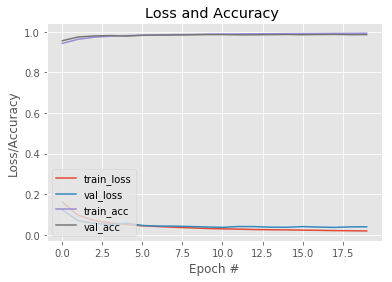

In [32]:
show_train_history(H)

In [33]:
evl_gen=generate_batch(train_path_list,train_label_list2,istraining=False)

In [34]:
model.evaluate_generator(evl_gen,steps=len(train_path_list)//bs+1,verbose=1)

2070/2070 [==============================] - 107s 52ms/step


[0.017298476830938533, 0.9936877903894945]

In [35]:
model.save_weights('model_weights.h5')

In [36]:
#test_path_list,id_list=get_test_path("../input/train/audio/yes/")

In [37]:
"""
pred=[]
for path in test_path_list:
    x=get_spectrogram([path])
    p=model.predict(np.array(x))  #别忘了np.array
    p=(np.argmax(p,1))[0]
    #print(p)
    #print(id2name[p])
    pred.append(id2name[p])  #之前不是append，外面一层还有一对括号。现在不用extend
print(pred)
"""

'\npred=[]\nfor path in test_path_list:\n    x=get_spectrogram([path])\n    p=model.predict(np.array(x))  #别忘了np.array\n    p=(np.argmax(p,1))[0]\n    #print(p)\n    #print(id2name[p])\n    pred.append(id2name[p])  #之前不是append，外面一层还有一对括号。现在不用extend\nprint(pred)\n'

In [38]:
"""
print(len(id_list))
print(len(test_path_list))
print(len(pred))
"""

'\nprint(len(id_list))\nprint(len(test_path_list))\nprint(len(pred))\n'

In [39]:
"""
result=pd.DataFrame({'fname': id_list,'label': pred})
result.to_csv('submission.csv', index=False)
"""

"\nresult=pd.DataFrame({'fname': id_list,'label': pred})\nresult.to_csv('submission.csv', index=False)\n"